<a href="https://colab.research.google.com/github/Cross-Caps/AFLI/blob/main/Notebook/RTM_theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Code to reproduce plots from the paper**

*Activation function design for deep networks: linearity and effective initialization*

Author: Vinayak Abrol <abrol@maths.ox.ac.uk>


In [ ]:
from __future__ import print_function
import os, sys
import numpy as np
from tqdm import tqdm

import matplotlib.cm as mplcm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from scipy.stats import norm, hypsecant
from scipy.integrate import quad, dblquad

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

epsabs = 1e-2
epsrel = 1e-2
dz = 0.05
zmin = -20.0
zmax = 20.0

## Experimental Setup

**Define activation function and its first derivative**

In [ ]:
#non-linearity and derivatives
from scipy.stats import hypsecant
from scipy.special import expit

def sech(x):
    return hypsecant.pdf(x) * np.pi
  
def hard_tanh(x):
  return relu(x+1)-relu(x-1)-1    
  
def D_hard_tanh(x):
  return np.heaviside(1-np.abs(x),1)
  
def modf(x):
  return np.abs(x)

def D_modf(x):
  return x/modf(x)

def relu(x):
  return np.where(x >= 0.0,x,0)

def D_relu(x):
  return np.where(x >= 0.0,1,0)
  
def selu(x):
  ALPHA  = 1.6732632423543772848170429916717
  LAMBDA = 1.0507009873554804934193349852946
  return LAMBDA*np.where(x >= 0.0,x,np.multiply(ALPHA, np.exp(x)) - ALPHA)
  #return LAMBDA*np.where(x >= 0.0,x,ALPHA*np.exp(x) - ALPHA)

def D_selu(x):
  ALPHA  = 1.6732632423543772848170429916717
  LAMBDA = 1.0507009873554804934193349852946
  return LAMBDA*np.where(x>= 0.0,1.0,np.multiply(np.exp(x), ALPHA))
  
def prelu(x):
  ALPHA  = 0.01
  return np.where(x >= 0.0, x, np.multiply(x, ALPHA))
  
def D_prelu(x):
  ALPHA  = 0.01
  return np.where(x >= 0, 1, ALPHA)

def elu(x,a):
  ALPHA  = a 
  return np.where(x >= 0.0, x, np.multiply(np.expm1(x), ALPHA))
  
def D_elu(x,a):
  ALPHA  = a
  return np.where(x >= 0.0, 1, elu(x,a) + ALPHA)

def sigmoid(x):
    sigm = 1. / (1. + np.exp(-x))
    return sigm

def swish(x):
  Beta=1
  return x*sigmoid(Beta*x)

def D_swish(x):
  Beta=1
  return Beta*swish(x)+sigmoid(Beta*x)-(Beta*sigmoid(Beta*x)*swish(x))

def softsign(x):
  return x/(1+np.abs(x))
  
def D_softsign(x):
  return np.sign(x)/((1+x)**2)

def gelu(x):
  return x*sigmoid(1.702*x)

def D_gelu(x):
  return 0.5*np.tanh(0.0356774*np.power(x, 3) + 0.797885*x) + (0.0535161*np.power(x,3) + 
    0.398942*x)*np.power(sech(0.0356774*np.power(x,3) + 0.797885*x),2) + 0.5


def stanh(x,a):
  return (a/2)*(np.tanh(x/a)-np.tanh(-x/a))

def D_stanh(x,a):
  return 0.5*(sech(x/a)**2 + sech(-x/a)**2)

def ssin(x,a):
  return (a/2)*(np.sin(x/a)-np.sin(-x/a))

def D_ssin(x,a):
  return 0.5*(np.cos(x/a) + np.cos(-x/a)) 

def eluS(x,a):
  return (a/2)*(elu(x/a,1)-elu(-x/a,1))

def D_eluS(x,a):
  return 0.5*(elu(x/a,1)+elu(-x/a,1))    

  
def activation(act,a=1):
  if act =='tanh':
    phi = np.tanh
    dphi = lambda x: sech(x)**2
    
  elif act=='Htanh' or act=='htanh':
    phi = lambda x: hard_tanh(x)
    dphi =lambda x: D_hard_tanh(x)
  
  elif act == 'relu':
      phi = lambda x: relu(x)
      dphi =lambda x: D_relu(x)
  
  elif act == 'selu':
      phi = lambda x: selu(x)
      dphi =lambda x: D_selu(x)
      
  elif act == 'swish':
      phi = lambda x: swish(x)
      dphi =lambda x: D_swish(x)    
      
  elif act == 'prelu':
      phi = lambda x: prelu(x)
      dphi =lambda x: D_prelu(x)
      
  elif act == 'elu':
      phi = lambda x: elu(x,a)
      dphi =lambda x: D_elu(x,a)

  elif act == 'gelu':
      phi = lambda x: gelu(x)
      dphi =lambda x: D_gelu(x)        
      
  elif act == 'mod':
      phi = lambda x: modf(x)
      dphi =lambda x: D_modf(x)
     
  elif act == 'softsign':
      phi = lambda x: softsign(x)
      dphi =lambda x: D_softsign(x)     
  
  elif act == 'stanh':
      phi = lambda x: stanh(x,a)
      dphi =lambda x: D_stanh(x,a)

  elif act == 'ssin':
      phi = lambda x: ssin(x,a)
      dphi =lambda x: D_ssin(x,a)

  elif act == 'eluS':
      phi = lambda x: eluS(x,a)
      dphi =lambda x: D_eluS(x,a)

  else:
    print('Unknown activation')
    exit()
      
  return phi, dphi   
      

**RTM Theory for DNNs: Implementation of Variance and Covariance Map** 

In [ ]:
def gauss_density(x):
  return np.exp(-x**2/2)/np.sqrt(2*np.pi)

class MeanField(object):
  def __init__(self, f, df):
    """
    Args: 
      f: activation function
      df: derivative of f. 
    """
    self.f = f
    self.df = df
  
  def qmap_density(self, x, q):
    # Compute the density function of the q-map
    return (self.f(np.sqrt(q)*x)**2)* gauss_density(x)
  
  def chi_density(self, x, q):
    return gauss_density(x) * (self.df(np.sqrt(q)*x)**2) 
  
  def sw_sb(self, q, chi1):
    #Return variances of weight and bias for a given chi and qstar=q for Critical line, set chi=1
    big_val = 1e12
    with warnings.catch_warnings():
      warnings.simplefilter("ignore") # silence underflow and overflow warning
      sw = chi1/quad(self.chi_density, -np.inf, np.inf, args= (q))[0]
      sb = q - sw * quad(self.qmap_density, -np.inf, np.inf, args= (q))[0]
    return sw, sb, sw*quad(self.qmap_density, -np.inf, np.inf, args= (q))[0]
  
  def q_chi(self, sw, sb):
    #Compute qstar and chi1 for a given weight and bais variance
    big_val = 1e12
    q=1
    with warnings.catch_warnings():
      warnings.simplefilter("ignore") # silence underflow and overflow warning
      for iter in range(500): # iterate over fixed point equation to get q*
        qstar = sb + sw * quad(self.qmap_density, -np.inf, np.inf, args= (q))[0]
        q=qstar
      chi1 = sw*quad(self.chi_density, -np.inf, np.inf, args= (q))[0]
    return qstar,chi1
  
def fast_integral(integrand, zmin, zmax, dz, ndim=1):
    zs = np.r_[zmin:zmax:dz]
    if ndim > 1:
        zgrid = np.meshgrid(*((zs,) * ndim))
    else:
        zgrid = (zs,)
    out = integrand(*zgrid)
    return out.sum(tuple(np.arange(ndim))) * dz**ndim
  
def covmap(q1, q2, q12, weight_sigma, bias_sigma, nonlinearity=np.tanh, zmin=-10, zmax=10, dz=dz, fast=True):
    #Compute covariance map 
    q1 = np.atleast_1d(q1)
    q2 = np.atleast_1d(q2)
    q12 = np.atleast_1d(q12)

    u1 = np.sqrt(q1)
    u2 = q12 / np.sqrt(q1)
    u3 = np.sqrt(q2 - q12**2 / q1 + 1e-8)  # XXX: tolerance fudge factor
    def integrand(z1, z2):
        return norm.pdf(z1[..., None]) * norm.pdf(z2[..., None]) * (
            nonlinearity(u1[None, None, :] * z1[..., None]) *
            nonlinearity(u2[None, None, :] * z1[..., None] + u3[None, None, :] * z2[..., None]))
    integral = fast_integral(integrand, zmin, zmax, dz, ndim=2)  
    return weight_sigma**2 * integral + bias_sigma**2

## Phase Diagram: EOC curves

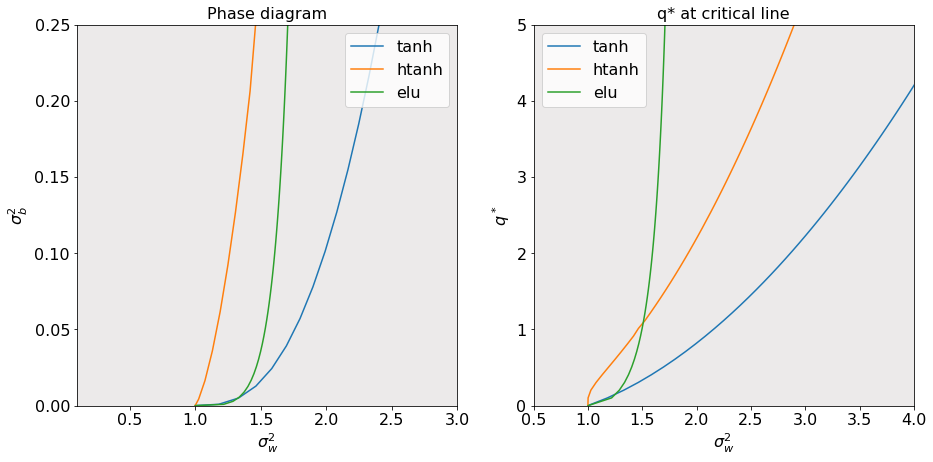

In [ ]:
#Let's pick few popular activation functions
dictphi=['tanh','htanh','elu']

n = 70
qrange = np.linspace(1e-5, 7, n)  #select a range of q_star values


fig, ax = plt.subplots(1,2,figsize=(15,7))
for act in dictphi:
  phi, dphi = activation(act)
  mf = MeanField(phi, dphi)
  sw = [mf.sw_sb(q, 1)[0] for q in qrange]   # compute weight and bias variance for q_star at criticality i.e., chi=1
  sb = [mf.sw_sb(q, 1)[1] for q in qrange]
  ax[0].plot(sw, sb,label=act)
  ax[1].plot(sw, qrange,label=act)

ax[0].set_title('Phase diagram', fontsize=16)
ax[0].set_xlabel('$\sigma_w^2$', fontsize=16)
ax[0].set_ylabel('$\sigma_b^2$', fontsize=16)
ax[0].set_xlim(0.1,3)
ax[0].set_ylim(0,.25)
ax[0].legend(loc="upper right",fontsize=16)
ax[0].tick_params(axis='both', labelsize=16)
ax[0].set_facecolor('#ECEAEA')

ax[1].set_title('q* at critical line', fontsize=16)
ax[1].set_xlabel('$\sigma_w^2$', fontsize=16)
ax[1].set_ylabel('$q^*$', fontsize=16)
ax[1].set_xlim(0.5, 4)
ax[1].set_ylim(0, 5)
ax[1].legend(loc='upper left',fontsize=16)
ax[1].tick_params(axis='both', labelsize=16)
ax[1].set_facecolor('#ECEAEA')
plt.show()

**How EOC varies for parametric activations?**

Let's demonstrate this with parametric ELU

Observe how EOC shrinks to become singleton ($0,\sqrt{2}$) in limit similar to the case of ReLU. Also note that except in case of yellow curve, in limit as $\sigma_b\rightarrow 0$, $\sigma_w\neq 1$.

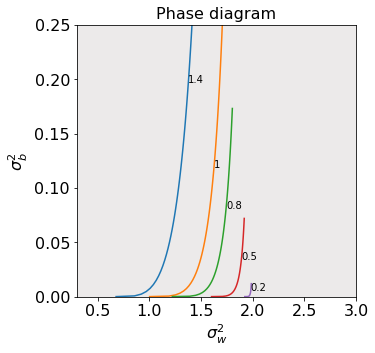

In [ ]:
#Let's pick parametric ELU
act='elu'
alpha = [1.4, 1, .8, .5 ,.2 ]
lg = "$\displaystyle\alpha$"

n = 70
qrange = np.linspace(1e-5, 5, n)  #select a range of q_star values

plt.figure(figsize=(5,5))
for alp in alpha:
  phi, dphi = activation(act,alp)
  mf = MeanField(phi, dphi)
  sw = [mf.sw_sb(q, 1)[0] for q in qrange]   # compute weight and bias variance for q_star at criticality
  sb = [mf.sw_sb(q, 1)[1] for q in qrange]
  plt.plot(sw, sb,label=r'$\alpha$ {}'.format(alp))
  plt.text(sw[35], sb[35], '{i}'.format(i=alp))

plt.xlim(0.3, 3)
plt.ylim(0, 0.25)
plt.title('Phase diagram', fontsize=16)
plt.xlabel('$\sigma_w^2$', fontsize=16)
plt.ylabel('$\sigma_b^2$', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.gca().set_facecolor('#ECEAEA')
plt.show()

 

## Correlation Dynamics 

**Fixed point convergence of correlations for different activation functions**

In limit $\rho*=1$ is always the fixed point of covariance map $R_{\phi,q*}(\sigma_w,\sigma_b,\phi,q*)$ i.e., even if inputs are uncorrelated to start with they will eventually become correlated. Observe the rate of convergence is very fast for ReLU/MOD comapred to ELU/Tanh. Suprisingly, GeLU doesn't have better or comparable rates as in case of ELU. Hence, for deeper networks activation function with slow convergence rate is prefrable. 

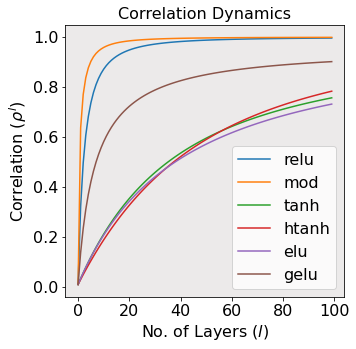

In [ ]:
# Let's pick few popular activation functions
dictphi=['relu','mod','tanh','htanh','elu','gelu']


def get_sig(act):
  #return sigma_w,sigma_b,q*   # Harcoded values to speedup ploting
  if   act=='relu':
    return np.sqrt(2.0),0,1.0
  elif act=='mod':
    return 1.0,0,1
  elif act=='tanh':
    return 1.1516998861216845, 0.06910990296631096, 0.2
  elif act=='htanh':
    return 1.012919795872811,  0.06360173889708144, 0.2
  elif act=='elu':
    return 1.1346045411558092, 0.05243710820049853, 0.2
  elif act=='gelu':
    return 1.7133982968880215, 0.09709102834229957, 0.2  
  else:
    print('Activation not available')
    exit()


rhoin = rhorange_traj = np.array([0.01])  # Initial covariance
nrhotraj = len(rhoin)
nt = 100 # Number of layers
rhotrajs = np.zeros((nrhotraj, nt))

plt.figure(figsize=(5,5))
for act in dictphi:
  sw_,sb_,q = get_sig(act)
  phi, dphi = activation(act,1)
  q1 = q
  rhotrajs = np.zeros((nrhotraj, nt))
  rhotrajs[:, 0] = rhoin * q1
  for t in range(1, nt):
    rhotrajs[:, t] = covmap(q1, q1, rhotrajs[:, t-1], sw_, sb_, phi)
  rhotrajs /= q1
  plt.plot(np.squeeze(rhotrajs), label=act)
  
plt.xlabel('No. of Layers ($l$)', fontsize=16)
plt.ylabel(r'Correlation ($\rho^{l})$', fontsize=16)
plt.title('Correlation Dynamics', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.gca().set_facecolor('#ECEAEA')
plt.show()

**What about Linear networks?**

In previous example we evaluated CMAP for a fixed $(\sigma_w,\sigma_b,q*)$. Here, we consider a linear network with $(\sigma_w/q*=1)$ and a $\sigma_b$ with in range (0-white, 0.2-red). Observe, rate of convergence of correlations increases exponentially with larger bias i.e., only bias=0 linear networks are iso-spectral (preserve correlations).

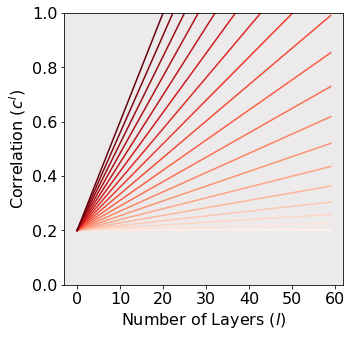

In [ ]:
NUM_COLORS = 20
cm = plt.get_cmap('Reds')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])


cin = crange_traj = np.array([0.2])  # Initial covariance
nctraj = len(cin)
nt = 60 # Number of layers
ctrajs = np.zeros((nctraj, nt))


act='linear'
params= np.linspace(0, 0.2, 20)
phi = lambda x: x
dphi = lambda x: 1


for i,param in enumerate(params):
  sw_,q = 1,1
  sb_=param
  q1 = q
  ctrajs = np.zeros((nctraj, nt))
  ctrajs[:, 0] = cin * q1

  for t in range(1, nt):
    ctrajs[:, t] = covmap(q1, q1, ctrajs[:, t-1], sw_, sb_, phi)
  ctrajs /= q1
  ax.plot(np.squeeze(ctrajs))#, label='$\sigma_b=$'+str(sb_))

plt.ylim(0, 1)  
plt.xlabel('Number of Layers ($l$)', fontsize=16)
plt.ylabel('Correlation ($c^{l})$', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.gca().set_facecolor('#ECEAEA')
plt.show()

**When are non-linear networks iso-spectral or atleast nearly iso-spectral?**

We demonstrate this by considering two different initial/input correlation values, and look at dynamics as we iteratively evaluate the CMAP. 

Note that double sided activations like Leaky-ReLU with EOC as Singleton are not considered here. Our aim is to choose/design the best nonlinearity which behave as near iso-spectral (preserve correlations) for very large depth networks, and this is possible at lower values of $q^*$. However, one might expect a different rate of convergence for correlations for different activation functions. In practice, we prefer working with normalized inputs i.e., $q^*=1$. It can be observed that overall Htanh and ELU are the best nonlinearities. At lower values of $q^*$ Htanh operates in linear region, but its outputs starts saturating for larger $q^*$ leading to correlated outputs at a higher rate. ELU being unbounded/linear in positive side leads to slow convergence and is best for higher values of $q^*$. 

 

*   This suggest that the best nonlinearity is the one having the minimum convergence rate while having the maximum possible $q^*$.
*   Given these observations a good starting point in choosing/designing a good iso-spectral nonlinearity is to have a large linear region around zero.
*   The particular structure of the nonlinear activation outside the linear region is observed to have little impact on the resulting training (refer to paper for more results).  


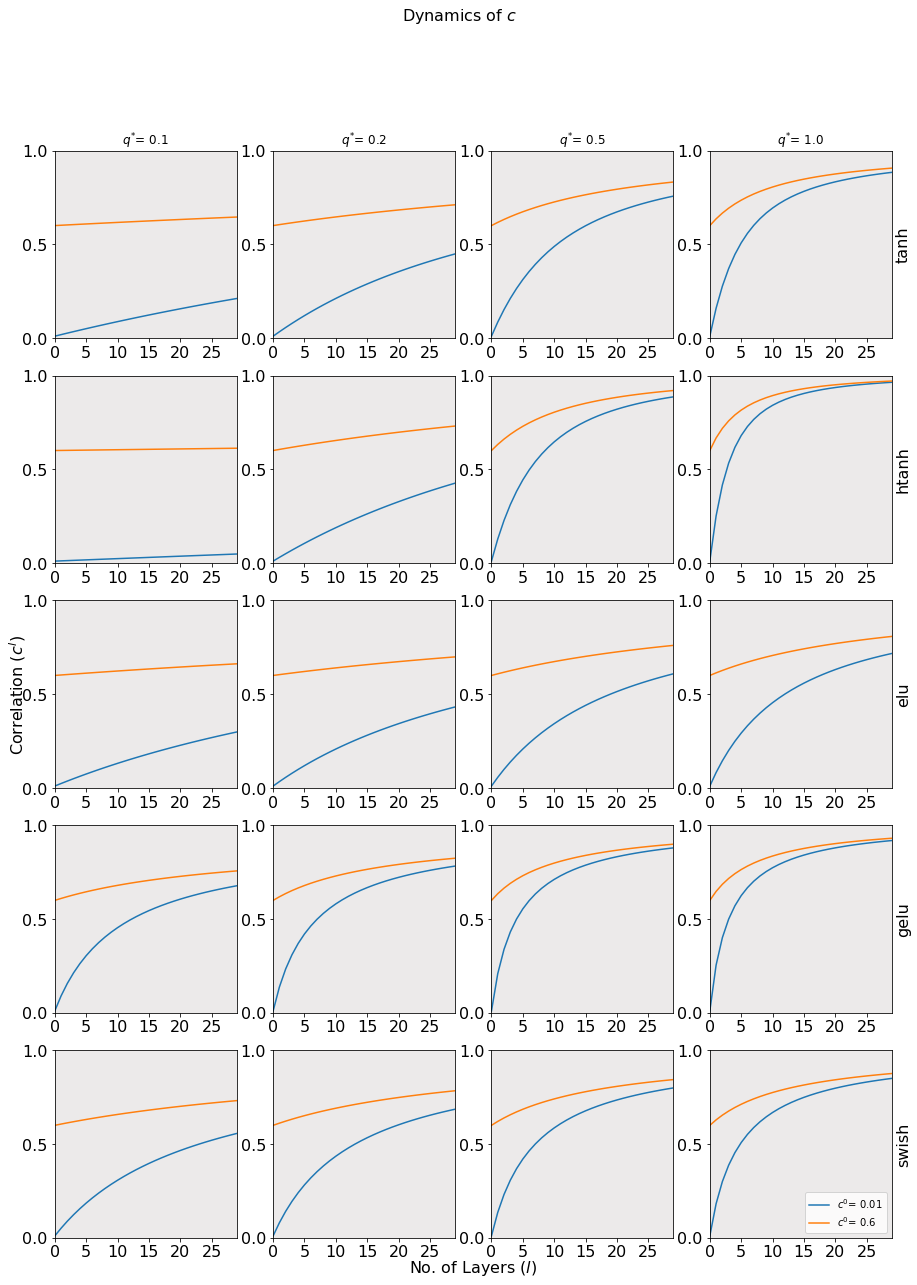

In [ ]:
cin = crange_traj = np.array([0.01,0.6])  # Initial covariance
nctraj = len(cin)
nt = 30 # Number of layers
ctrajs = np.zeros((nctraj, nt))

q_range = [.1, .2, .5, 1]
dictphi=['tanh','htanh','elu','gelu','swish']

fig=plt.figure(figsize=(15,20))
for j,act in enumerate(dictphi):
  phi,dphi=activation(act )
  mf = MeanField(phi, dphi)
  for i, q in enumerate(q_range):
    sw_ = np.sqrt(mf.sw_sb(q, 1)[0])
    sb_ = np.sqrt(mf.sw_sb(q, 1)[1])

    q1 = q
    ctrajs = np.zeros((nctraj, nt))
    ctrajs[:, 0] = cin * q1

    for t in range(1, nt):
      ctrajs[:, t] = covmap(q1, q1, ctrajs[:, t-1], sw_, sb_, phi)

    ctrajs /= q1
    plt.subplot(len(dictphi),len(q_range),j*len(q_range)+i+1)
    plt.plot(ctrajs[0], label='{0:s} {1:.2f}'.format('$c^{0}$=', cin[0]))
    plt.plot(ctrajs[1], label='{0:s} {1:.1f}'.format('$c^{0}$=', cin[1]))
    if j*len(q_range)+i+1 in np.arange(len(q_range)+1):
      plt.title('{0:s} {1:.1f}'.format('$q^{*}$=', q))
    plt.yticks([0, 0.5, 1])
    plt.ylim(0, 1)
    plt.xlim(0, nt - 1) 
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.gca().set_facecolor('#ECEAEA')
    if j*len(q_range)+i+1 in [4,8,12,16,20,24]:
      plt.gca().yaxis.set_label_position("right")
      plt.ylabel(act,fontsize=16)
          

plt.legend()
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('No. of Layers ($l$)', fontsize=16)
plt.ylabel('Correlation ($c^{l})$', fontsize=16)
fig.suptitle('Dynamics of $c$ \n', fontsize=16)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.2, hspace=.2)   

## CMAP Contour Visualization



Using contour plot we will show how for $\chi<1$ we achieve a different fixed point $\rho*< 1$ for $R_{\phi,q*}(.)$, and for $\chi>1$, $\rho*=1$ is the only fixed point.

**Define range for** $\sigma_w$ **and** $\sigma_b$ **for computing** $\rho^{*}$

In [ ]:
act='tanh'
phi,dphi=activation(act)
mf = MeanField(phi, dphi)

nw=40
nb=40
W_var = np.linspace(0.5, 3, nw) 
b_var = np.linspace(0.0001, .25, nb)
W_var[8]=1 # insure one sigma_w^2 value to be 1

weight_sigmas=np.sqrt(W_var)
bias_sigmas=np.sqrt(b_var)

**Compute fixed points of the** $V_{\phi}(.)$ **variance-map**

In [ ]:
# Range for squared lengths q
nq = 100
qmax = 15
qrange = np.linspace(0, qmax, nq)
qstars = np.zeros((nw, nb))

for widx, wv in enumerate(tqdm(W_var)):
    # Compute fixed points
    qstars[widx, :] =  [mf.q_chi(wv,bv)[0] for bv in b_var]                                  

**Compute fixed points of the** $R_{\phi,q*}(.)$ **covariance-map for contour plot**

In [ ]:
nq = 100
c12s = np.linspace(0, 1.0, nq)
crange = c12s

rhostars = np.zeros((nw, nb))
for widx, weight_sigma in enumerate(tqdm(weight_sigmas)):
    for bidx, bias_sigma in enumerate(bias_sigmas):
        q1 = qstars[widx, bidx]
        cin = (c12s * q1)
        cout = covmap(q1, q1,  cin, weight_sigma, bias_sigma, phi)
        # Remove  fixed point at cin = q*
        rhostar = cin[np.argmin(np.abs(cin[:-1] - cout[:-1]))]
        rhostars[widx, bidx] = rhostar
        
rhostars_unnormalized = rhostars.copy()
rhostars /= qstars # covariance to correlation conversion

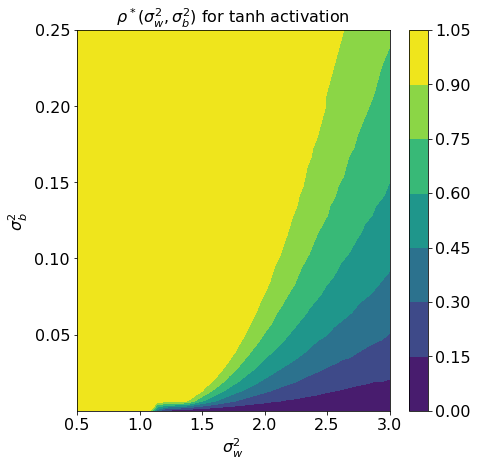

In [ ]:
plt.figure(figsize=(7, 7))
plt.contourf( W_var,b_var, rhostars.T, vmin=0, vmax=.999)
cb=plt.colorbar() 
for t in cb.ax.get_yticklabels():
     t.set_fontsize(16)

plt.title(r'$\rho^*(\sigma_w^2, \sigma_b^2)$ '+'for ' + act + ' activation', fontsize=16)     
plt.xlabel(r'$\sigma_w^2$ ', fontsize=16)
plt.ylabel(r'$\sigma_b^2$ ', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()